# WOA09 original dataset selected areas smoothing  

In [19]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import matplotlib.colors as mcolors
from matplotlib.colors import LogNorm
import gsw as gsw
from netCDF4 import Dataset


from matplotlib import rcParams
import matplotlib as mpl
from mpl_toolkits.basemap import Basemap

%matplotlib inline

In [20]:
! date

Wed Apr 23 11:14:18 CEST 2025


In [21]:
def Arc_Bat(ztype='isol1000') :
        locpath='/data0/project/drakkar/CONFIGS/CREG025.L75/GRID/'
        locfile='CREG025.L75_domain_cfg.nc'
        fieldbat=Dataset(locpath+locfile)
        lon  = np.squeeze(fieldbat.variables['nav_lon'])
        lat  = np.squeeze(fieldbat.variables['nav_lat'])
        My_var = np.squeeze(fieldbat.variables['bathy_meter'])

        spval = 0.
        My_var= np.ma.masked_where(My_var <= spval,My_var)

        if ztype == 'isol1000' :
                vmin=1000. ; vmax=2000.
                contours=[1000.]
                limits=[vmin,vmax]
                myticks=[1000.]
        elif ztype == 'isol1500' :
                vmin=1500. ; vmax=2000.
                contours=[1500.]
                limits=[vmin,vmax]
                myticks=[1500.]
        elif ztype == 'isomonarc' :
                vmin=500. ; vmax=4000.
                contours=[500.,2000.,4000.]
                limits=[vmin,vmax]
                myticks=[500.,2000.,4000.]
        elif ztype == 'isol500' :
                vmin=500. ; vmax=500.
                contours=[500.]
                limits=[vmin,vmax]
                myticks=[500.]
        else:
                vmin=0. ; vmax=8000.
                contours=[100.,500.,1000.,2000.,3000.,3500.,4000.]
                limits=[vmin,vmax]
                myticks=[100.,500.,1000.,2000.,3000.,3500.,4000.]

        #
        #rcParams['text.latex.unicode']=True
        plt.rcParams['contour.negative_linestyle'] = 'solid'
        #
        m = Basemap(projection='npstere',boundinglat=65,lon_0=-60, resolution='i')
        norm = mpl.colors.Normalize(vmin=limits[0], vmax=limits[1])
        pal = plt.cm.get_cmap('binary')
        X,Y = m(lon,lat)

        # contour (optional)
        CS2 = m.contour(X, Y, My_var, linewidths=0.5,levels=contours, colors='black', alpha=1.)
        plt.clabel(CS2, CS2.levels, inline=True, fmt='%.0f', fontsize=3)

        return m, X, Y


In [22]:
def Arc_plot(lon,lat,tab,contours,limits,myticks=None,name=None,zmy_cblab=None,zmy_cmap=None,filename='test.pdf',zvar=None):
        #
# Les 2 lignes suivantes posent un probleme a l'execution lie a LaTex ....
#       rcParams['text.usetex']=True
#       rcParams['text.latex.unicode']=True
        #rcParams['font.family']='serif'

        plt.rcParams['contour.negative_linestyle'] = 'solid'
        #
        m = Basemap(projection='npstere',boundinglat=65,lon_0=-60, resolution='i')

        if zvar == 'sivolu' or zvar == 'siconc'  or zvar == 'ssh' or zvar == 'socurl' :
                zfontsize=10.
        else:
                zfontsize=6.

        if zvar != 'Bathy' :
                m.drawparallels(np.arange(-90.,91.,5.),labels=[False,False,False,False], size=zfontsize, linewidth=0.3)
                m.drawmeridians(np.arange(-180.,181.,20.),labels=[True,False,False,True], size=zfontsize, latmax=90.,linewidth=0.3)
                m.fillcontinents(color='grey',lake_color='white')

        norm = mpl.colors.Normalize(vmin=limits[0], vmax=limits[1])

        if zmy_cmap != None :
                pal = zmy_cmap
        else:
                pal = plt.cm.get_cmap('coolwarm')
                #pal = plt.cm.get_cmap('terrain')

        X,Y = m(lon,lat)
        C = m.contourf(X,Y,tab,contours,cmap=pal,norm=norm,extend='both')
        if zvar == 'ssh':
                CS=m.contour(X, Y, tab, linewidths=0.5, levels=npy.arange(limits[0],limits[1],5.), colors='k', alpha=0.4)

        ############################################################################################################
        ############################################################################################################
        moorplot=0
        if moorplot == 1 :
                bx_ARCB={'name':'B'  ,'lon_min':-150.,'lon_max':-150.,'lat_min':78.,'lat_max':78.}
                bx_ARCM={'name':'M1' ,'lon_min': 125.,'lon_max': 125.,'lat_min':78.,'lat_max':78.}
                bx_EURA={'name':'EUR','lon_min':  60.,'lon_max':  60.,'lat_min':85.,'lat_max':85.}

                All_box=[bx_ARCB,bx_EURA]
                for box in All_box:
                        lats = [box['lat_min'],box['lat_max']]
                        lons = [box['lon_min'],box['lon_max']]
                        x,y = m(lons,lats)
                        m.scatter(x,y,3,marker='o', color='r')
                        #m.plot(x,y,linewidth=2, color='g')
        ############################################################################################################
        ############################################################################################################

        # colorbar      
        if myticks is None:
                cbar = plt.colorbar(C,format='%.2f',orientation='vertical',shrink=0.8)
        else:
                if zvar == 'votemper' or zvar == 'vosaline' or zvar == 'sivolu' :
                        cbar = plt.colorbar(C,format='%.2f',orientation='vertical',shrink=0.8,drawedges=True)
                else:
                        cbar = plt.colorbar(C,format='%.0f',orientation='vertical',shrink=0.8,drawedges=True)

                cbar.set_label(zmy_cblab,fontsize=zfontsize)
                cl = plt.getp(cbar.ax, 'ymajorticklabels')
                plt.setp(cl, fontsize=zfontsize)

        plt.title(name,fontsize=zfontsize)

        return m

> # Apply the smoothing to the WOA09 dataset interpolated on 75 levels

In [35]:
# Funtion to compute Brunt-Vaissalla frequency and number of grid points with instability
def N2_Insta_Z75(zds,zsal,ztem,zpre,zmsk):
    # Compute the Brunt-Vaissalla frequency
    WDINT_N2,p_imd=gsw.Nsquared(zds[zsal].values,\
                                zds[ztem].values,\
                                zpre,axis=0)

    # Build a 2D map to see how many instabilities occur on each water column
    num_WDINT_N2=np.where(WDINT_N2 < 0.,1.,0.)
    # Remove the grid points in the first 50m
    num_WDINT_N2[0:18,:,:]=0. 
    # Remove the grid points below 1500m
    num_WDINT_N2[50::,:,:]=0. 

    ZCUM_INS=np.sum(num_WDINT_N2,axis=0)
    ZCUM_INS=xr.where(np.isnan(zmsk),np.nan,ZCUM_INS)

    return ZCUM_INS,WDINT_N2

In [24]:
def Fsmooth_Z75(ds_in,zvar_in,arr_ori):
    # Temperature 
    arr_sm=ds_in[zvar_in].rolling(z=3,center=True).mean()
    # Then replace the NaN at the top and bottom of the Dataset with original field
    arr_sm[0,:,:]=arr_ori[0,:,:]
    arr_sm[74,:,:]=arr_ori[74,:,:]
    
    return arr_sm

In [25]:
INDIR='/data0/project/drakkar/CONFIGS/CREG12.L75/CREG12.L75-I/'
ds_initT=xr.open_mfdataset(INDIR+'woa09_ConTem_monthly_1deg_CT_CMA_drowned_Ex_L75.nc',chunks={'lat0':90,'lon0':180})
#ds_initT

In [26]:
INDIR='/data0/project/drakkar/CONFIGS/CREG12.L75/CREG12.L75-I/'
ds_initS=xr.open_mfdataset(INDIR+'woa09_SalAbs_monthly_1deg_SA_CMA_drowned_Ex_L75.nc',chunks={'lat0':90,'lon0':180})
#ds_initS

>>>> ## Get the original longitudes range [0,360]

In [27]:
INORI='/data0/project/drakkar/REFERENCE_DATA/WOA2009/DATA/1degx1deg/'
ds_latlon1D_0360=xr.open_dataset(INORI+'woa09_temperature_monthly_1deg.nc',\
                                 drop_variables=['lat_bnds','lon_bnds','climatology_bnds','crs','t_mn','t_dd','t_dd','t_ma','t_sd','t_se','t_oa','t_gp'],\
                                 decode_times=False)
#ds_latlon1D_0360

>>>> ## Build land/sea mask

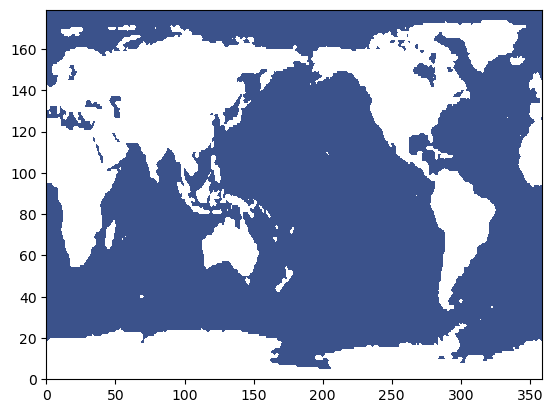

In [28]:
mask2D=xr.where(np.isnan(ds_latlon1D_0360['t_an'].isel(time=0,depth=0)),np.nan,1)
plt.contourf(mask2D)

>>>> ## Get 2D lat/lon as depth as well

In [29]:
INDIR='/data0/project/drakkar/CONFIGS/CREG12.L75/CREG12.L75-I/'
ds_latlonZ=xr.open_dataset(INDIR+'woa09_depth_Ex_L75.nc')
ds_latlonZ=ds_latlonZ.rename({'lat0':'lat','lon0':'lon'})
#ds_latlonZ

In [30]:
test=ds_initS['SA'].isel(time_counter=0)
test.shape

(75, 180, 360)

In [31]:
ds_woa09_z75=xr.Dataset()
ds_woa09_z75['SA']=(('z','lat','lon'),ds_initS['SA'].isel(time_counter=0).data)
ds_woa09_z75['CT']=(('z','lat','lon'),ds_initT['CT'].isel(time_counter=0).data)
ds_woa09_z75.coords['lat']=(('lat'),ds_latlon1D_0360['lat'].data)
ds_woa09_z75.coords['lon']=(('lon'),ds_latlon1D_0360['lon'].data)
ds_woa09_z75.coords['depth']=(('z'),ds_latlonZ['depth'].isel(time_counter=0,lat=0,lon=0).data)
ds_woa09_z75

<xarray.Dataset>
Dimensions:  (z: 75, lat: 180, lon: 360)
Coordinates:
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
    depth    (z) float32 0.5058 1.556 2.668 ... 5.495e+03 5.698e+03 5.902e+03
Dimensions without coordinates: z
Data variables:
    SA       (z, lat, lon) float64 dask.array<chunksize=(75, 90, 180), meta=np.ndarray>
    CT       (z, lat, lon) float64 dask.array<chunksize=(75, 90, 180), meta=np.ndarray>

In [32]:
# Need to convert latitudes & longitudes into 2D field and renames their dimensions
wlat2D=np.tile(ds_woa09_z75['lat'],(ds_woa09_z75.sizes['lon'],1)).T
wzlon=np.reshape(ds_woa09_z75['lon'].data,(1,ds_woa09_z75.sizes['lon']))
wlon2D=np.tile(wzlon,(ds_woa09_z75.sizes['lat'],1))

In [33]:
zzlat3D=np.reshape(ds_woa09_z75['lat'].data,(ds_woa09_z75.sizes['lat'],1))
zlat3D=np.tile(zzlat3D,(1,ds_woa09_z75.sizes['lon']))
lat3D=np.tile(zlat3D,(ds_woa09_z75.sizes['z'],1,1))
zplt=np.reshape(ds_woa09_z75['depth'].data,(ds_woa09_z75.sizes['z'],1,1))
zplt.shape
# Duplicate this depth to fit the T/S on a global grid
z3D=np.tile(zplt,(1,ds_woa09_z75.sizes['lat'],ds_woa09_z75.sizes['lon']))
lat3D.shape

(75, 180, 360)

In [34]:
# Define a pressure from depth
pressure=gsw.p_from_z(-z3D,lat3D)

In [38]:
# Calulation of the Brunt-Vaissalla frequency 
CUM_Instab, N2_out=N2_Insta_Z75(ds_woa09_z75,'SA','CT',pressure,mask2D)
ds_woa09_z75['Instab_ini']=(('lat','lon'),CUM_Instab.data)

# Save the Brunt-Vaissalla in a specific Dataset because of 1 less vertical level
ds_outN2_Z75=xr.Dataset()
ds_outN2_Z75['N2_ini']=(('z','lat','lon'),N2_out)
ds_outN2_Z75.coords['lat']=ds_woa09_z75['lat']
ds_outN2_Z75.coords['lon']=ds_woa09_z75['lon']
ds_outN2_Z75.coords['depth']=ds_woa09_z75['depth'].isel(z=slice(0,74))

In [94]:
%%time
# Choose which variable to smooth 
my_choice='both'  # both, sal or tem
num_smooth=15

ds_woa09_z75['cum_smooth']=(('lat','lon'),np.zeros((ds_woa09_z75.sizes['lat'],ds_woa09_z75.sizes['lon'])))

if my_choice == 'both':
    print('>>>>>>>>>>>>>  Both CT/SA are smoothed')

    for zsmo in set(np.arange(num_smooth)+1):
        print('                      Smooth #:'+str(zsmo))
        if zsmo == 1 : 
            zCT='CT'  ; zSA='SA'   ; zN2='N2_ini'  ;  zinstab='Instab_ini'
        else:
            zCT='CT_sm'  ; zSA='SA_sm' ; zN2='N2_sm'  ;  zinstab='Instab_sm'
            
        # DETECT THE INSTABILITIES
        ##########################
        # Calculation of the Brunt-Vaissalla frequency 
        CUM_Instab, N2_out=N2_Insta_Z75(ds_woa09_z75,zSA,zCT,pressure,mask2D)
        ds_woa09_z75[zinstab]=(('lat','lon'),CUM_Instab.data)
        # Save the Brunt-Vaissalla in a specific Dataset because of 1 less vertical level
        ds_outN2_Z75[zN2]=(('z','lat','lon'),N2_out)

        # FIND INDICES WHERE AT LEAST ONE INSTABILITY ARISES 
        #####################################################
        maskinstab=ds_woa09_z75[zinstab] > 0.
        # Then make the previous 2D mask 3D 
        maskinstab3D = maskinstab.broadcast_like(ds_woa09_z75.CT) 
        
        # KEEP TRACE OF HOW MANY SMOOTH HAVE BEEN APPLIED
        ds_woa09_z75['cum_smooth']=xr.where(maskinstab,ds_woa09_z75['cum_smooth']+1.,ds_woa09_z75['cum_smooth'])
        
        # APPLY SMOOTHING EVERYWHERE AT ONCE
        #####################################
        Zrollemean=Fsmooth_Z75(ds_woa09_z75,zCT,ds_woa09_z75['CT'].data)
        ds_woa09_z75['CT_sm']=xr.where(maskinstab3D, Zrollemean ,ds_woa09_z75[zCT].data )
        
        Zrollemean=Fsmooth_Z75(ds_woa09_z75,zSA,ds_woa09_z75['SA'].data)
        ds_woa09_z75['SA_sm']=xr.where(maskinstab3D, Zrollemean ,ds_woa09_z75[zSA].data )

        if True:
            # CHECK INSTABILITIES FROM THE NEW SMOOTHED FIELDS
            ##################################################
            # Calculation of the Brunt-Vaissalla frequency 
            CUM_Instab, N2_out=N2_Insta_Z75(ds_woa09_z75,'SA_sm','CT_sm',pressure,mask2D)
            ds_woa09_z75['Instab_sm']=(('lat','lon'),CUM_Instab.data)
            # Save the Brunt-Vaissalla in a specific Dataset because of 1 less vertical level
            ds_outN2_Z75['N2_sm']=(('z','lat','lon'),N2_out)

        ltitle='Both smoothed '+str(num_smooth)+' times'
    

>>>>>>>>>>>>>  Both CT/SA are smoothed
                      Smooth #:1
                      Smooth #:2
                      Smooth #:3
                      Smooth #:4
                      Smooth #:5
                      Smooth #:6
                      Smooth #:7
                      Smooth #:8
                      Smooth #:9
                      Smooth #:10
                      Smooth #:11
                      Smooth #:12
                      Smooth #:13
                      Smooth #:14
                      Smooth #:15
CPU times: user 1min 50s, sys: 10 s, total: 2min
Wall time: 1min 17s


In [77]:
ds_woa09_z75

<xarray.Dataset>
Dimensions:     (z: 75, lat: 180, lon: 360)
Coordinates:
  * lat         (lat) float32 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon         (lon) float32 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
    depth       (z) float32 0.5058 1.556 2.668 ... 5.495e+03 5.698e+03 5.902e+03
    time        float32 15.0
Dimensions without coordinates: z
Data variables:
    SA          (z, lat, lon) float64 dask.array<chunksize=(75, 90, 180), meta=np.ndarray>
    CT          (z, lat, lon) float64 dask.array<chunksize=(75, 90, 180), meta=np.ndarray>
    cum_smooth  (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 5.0 5.0 5.0 5.0 5.0
    Instab_ini  (lat, lon) float64 nan nan nan nan nan ... 1.0 1.0 1.0 1.0 1.0
    CT_sm       (z, lat, lon) float64 dask.array<chunksize=(73, 90, 180), meta=np.ndarray>
    SA_sm       (z, lat, lon) float64 dask.array<chunksize=(73, 90, 180), meta=np.ndarray>
    Instab_sm   (lat, lon) float64 nan nan nan nan nan ... 1.0 1.0 1.0 1.0 1.0

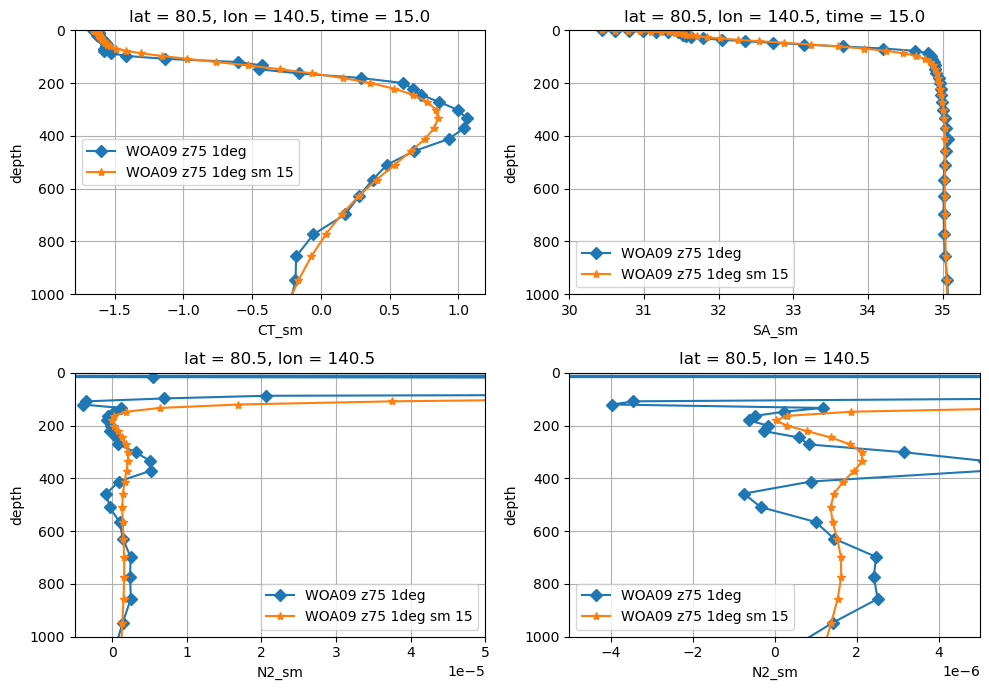

In [95]:
plt.figure(figsize=(10,7))

# Latitude & longitude
loc_x=140.  ;  loc_y=80.   ;  zdep=1000.  ; zdepup=0.

plt.subplot(221)
ds_woa09_z75['CT'].sel(lat=loc_y,lon=loc_x,method='nearest').plot(y='depth',marker='D',label='WOA09 z75 1deg')
ds_woa09_z75['CT_sm'].sel(lat=loc_y,lon=loc_x,method='nearest').plot(y='depth',marker='*',label='WOA09 z75 1deg sm '+str(num_smooth))
plt.legend()
plt.ylim([zdep,zdepup])
plt.grid(True)

plt.subplot(222)
ds_woa09_z75['SA'].sel(lat=loc_y,lon=loc_x,method='nearest').plot(y='depth',marker='D',label='WOA09 z75 1deg')
ds_woa09_z75['SA_sm'].sel(lat=loc_y,lon=loc_x,method='nearest').plot(y='depth',marker='*',label='WOA09 z75 1deg sm '+str(num_smooth))
plt.legend()
plt.xlim([30,35.5])
plt.ylim([zdep,zdepup])
plt.grid(True)

if True:
    plt.subplot(223)
    ds_outN2_Z75['N2_ini'].sel(lat=loc_y,lon=loc_x,method='nearest').plot(y='depth',marker='D',label='WOA09 z75 1deg')
    ds_outN2_Z75['N2_sm'].sel(lat=loc_y,lon=loc_x,method='nearest').plot(y='depth',marker='*',label='WOA09 z75 1deg sm '+str(num_smooth))

    plt.legend()
    plt.xlim([-0.5e-5,5e-5])
    plt.ylim([zdep,zdepup])
    plt.grid(True)
    
    plt.subplot(224)
    ds_outN2_Z75['N2_ini'].sel(lat=loc_y,lon=loc_x,method='nearest').plot(y='depth',marker='D',label='WOA09 z75 1deg')
    ds_outN2_Z75['N2_sm'].sel(lat=loc_y,lon=loc_x,method='nearest').plot(y='depth',marker='*',label='WOA09 z75 1deg sm '+str(num_smooth))

    plt.legend()
    plt.xlim([-0.5e-5,0.5e-5])
    plt.ylim([zdep,zdepup])
    plt.grid(True)
    
plt.tight_layout()

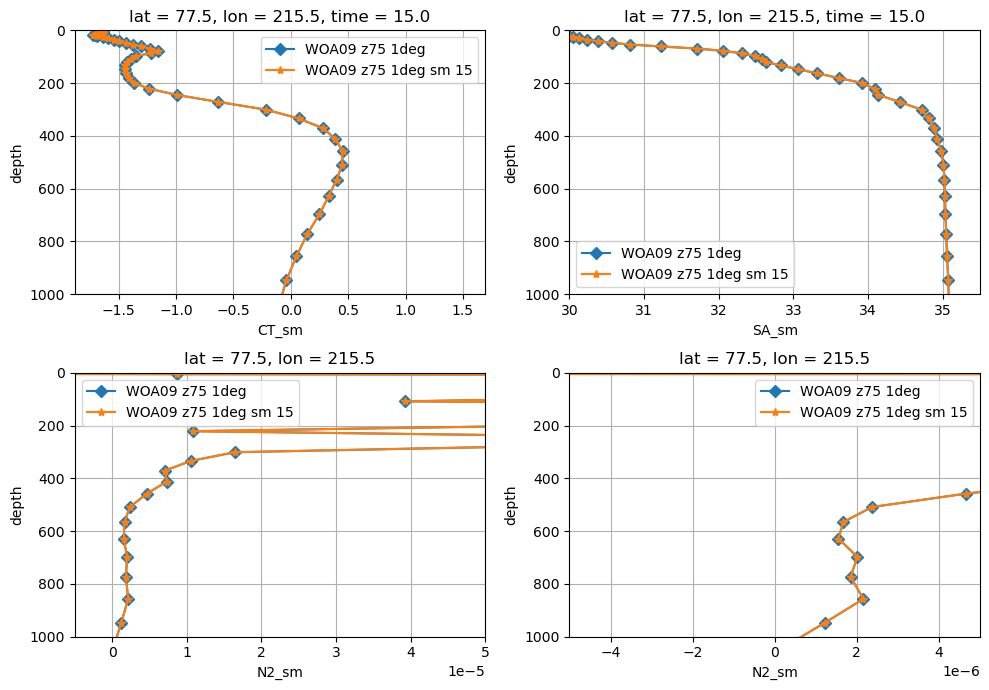

In [96]:
plt.figure(figsize=(10,7))

# Latitude & longitude
loc_x=215.  ;  loc_y=77.   ;  zdep=1000.     ; zdepup=0.

plt.subplot(221)
ds_woa09_z75['CT'].sel(lat=loc_y,lon=loc_x,method='nearest').plot(y='depth',marker='D',label='WOA09 z75 1deg')
ds_woa09_z75['CT_sm'].sel(lat=loc_y,lon=loc_x,method='nearest').plot(y='depth',marker='*',label='WOA09 z75 1deg sm '+str(num_smooth))
plt.legend()
plt.ylim([zdep,zdepup])
plt.ylim([zdep,0.])
plt.grid(True)

plt.subplot(222)
ds_woa09_z75['SA'].sel(lat=loc_y,lon=loc_x,method='nearest').plot(y='depth',marker='D',label='WOA09 z75 1deg')
ds_woa09_z75['SA_sm'].sel(lat=loc_y,lon=loc_x,method='nearest').plot(y='depth',marker='*',label='WOA09 z75 1deg sm '+str(num_smooth))
plt.legend()
plt.xlim([30,35.5])
plt.ylim([zdep,zdepup])
plt.grid(True)

if True:
    plt.subplot(223)
    ds_outN2_Z75['N2_ini'].sel(lat=loc_y,lon=loc_x,method='nearest').plot(y='depth',marker='D',label='WOA09 z75 1deg')
    ds_outN2_Z75['N2_sm'].sel(lat=loc_y,lon=loc_x,method='nearest').plot(y='depth',marker='*',label='WOA09 z75 1deg sm '+str(num_smooth))
    plt.legend()
    plt.xlim([-0.5e-5,5e-5])
    plt.ylim([zdep,zdepup])
    plt.grid(True)
    
    plt.subplot(224)
    ds_outN2_Z75['N2_ini'].sel(lat=loc_y,lon=loc_x,method='nearest').plot(y='depth',marker='D',label='WOA09 z75 1deg')
    ds_outN2_Z75['N2_sm'].sel(lat=loc_y,lon=loc_x,method='nearest').plot(y='depth',marker='*',label='WOA09 z75 1deg sm '+str(num_smooth))

    plt.legend()
    plt.xlim([-0.5e-5,0.5e-5])
    plt.ylim([zdep,zdepup])
    plt.grid(True)
    
plt.tight_layout()

Text(0.5, 1.0, 'WOA09 dataset z75 1deg \n # grid points with instabilities over the water column')

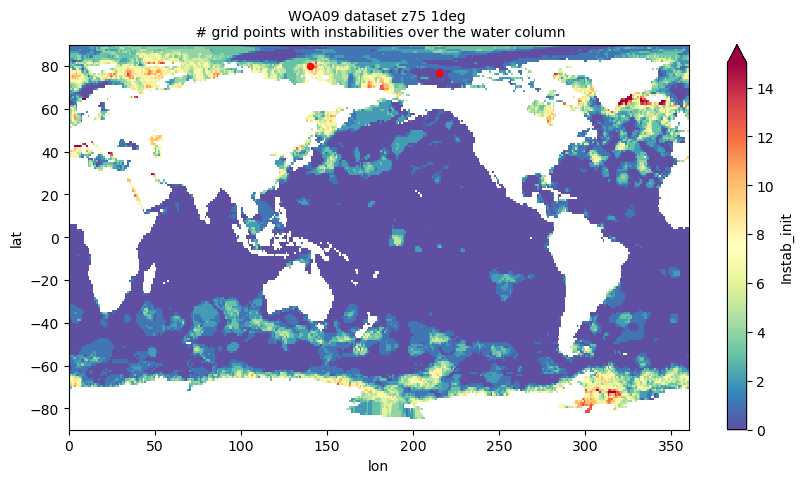

In [37]:
plt.figure(figsize=(10,5))

ds_woa09_z75['Instab_ini'].plot(cmap='Spectral_r',vmax=15)
# Latitude & longitude
loc_x=140  ;  loc_y=80
plt.scatter(loc_x,loc_y,20,marker='o', color='r')
loc_x=215  ;  loc_y=77
plt.scatter(loc_x,loc_y,20,marker='o', color='r')
plt.title( 'WOA09 dataset z75 1deg \n # grid points with instabilities over the water column',fontsize=10)


/tmp/ipykernel_3520/2790957951.py:44: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  pal = plt.cm.get_cmap('binary')


Text(0.5, 1.0, 'WOA09 dataset z75 1deg \n # grid points with instabilities over the water column')

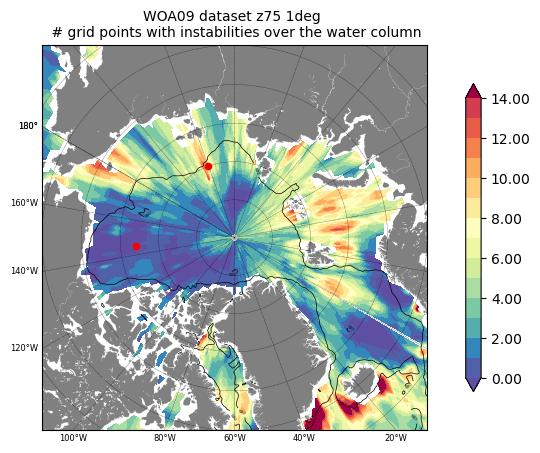

In [38]:
plt.figure(figsize=(10,5))

Arc_Bat(ztype='isol500')
m=Arc_plot(wlon2D,wlat2D,ds_woa09_z75['Instab_ini'],np.arange(0,15),[0.,15.],zmy_cmap='Spectral_r')
loc_x=140  ;  loc_y=80
x,y = m(loc_x,loc_y)
m.scatter(x,y,20,marker='o', color='r')
loc_x=215  ;  loc_y=77
x,y = m(loc_x,loc_y)
m.scatter(x,y,20,marker='o', color='r')
plt.title( 'WOA09 dataset z75 1deg \n # grid points with instabilities over the water column',fontsize=10)


Text(0.5, 1.0, 'WOA09 dataset z75 1deg Both smoothed 15 times \n # grid points with instabilities over the water column')

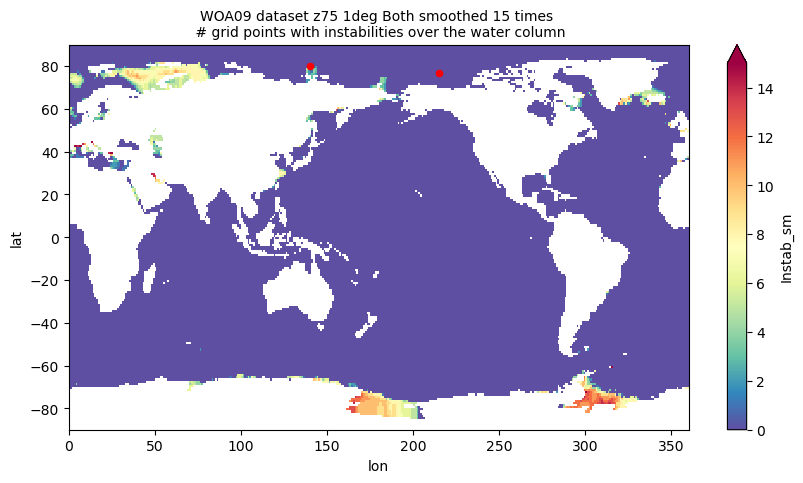

In [97]:
plt.figure(figsize=(10,5))

ds_woa09_z75['Instab_sm'].plot(cmap='Spectral_r',vmax=15)
# Latitude & longitude
loc_x=140  ;  loc_y=80
plt.scatter(loc_x,loc_y,20,marker='o', color='r')
loc_x=215  ;  loc_y=77
plt.scatter(loc_x,loc_y,20,marker='o', color='r')
plt.title( 'WOA09 dataset z75 1deg '+ltitle+' \n # grid points with instabilities over the water column',fontsize=10)


/tmp/ipykernel_3321/2790957951.py:44: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  pal = plt.cm.get_cmap('binary')


Text(0.5, 1.0, 'WOA09 dataset z75 1deg Both smoothed 15 times \n # grid points with instabilities over the water column')

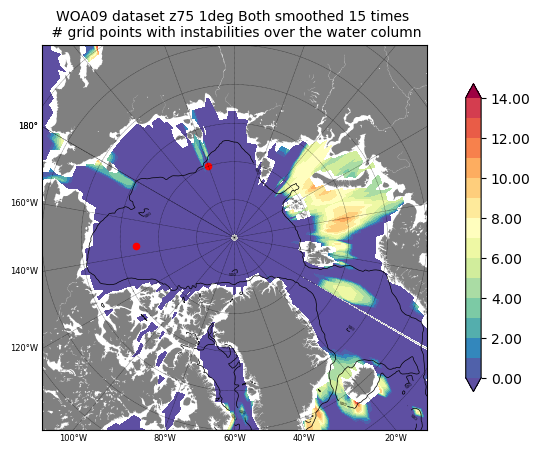

In [98]:
plt.figure(figsize=(10,5))

#plt.subplot(221)
Arc_Bat(ztype='isol500')
m=Arc_plot(wlon2D,wlat2D,ds_woa09_z75['Instab_sm'],np.arange(0,15),[0.,15.],zmy_cmap='Spectral_r')
loc_x=140  ;  loc_y=80
x,y = m(loc_x,loc_y)
m.scatter(x,y,20,marker='o', color='r')
loc_x=215  ;  loc_y=77
x,y = m(loc_x,loc_y)
m.scatter(x,y,20,marker='o', color='r')
plt.title( 'WOA09 dataset z75 1deg '+ltitle+' \n # grid points with instabilities over the water column',fontsize=10)


/tmp/ipykernel_3321/2790957951.py:44: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  pal = plt.cm.get_cmap('binary')


Text(0.5, 1.0, 'WOA09 dataset z75 1deg \n # of smooth applied')

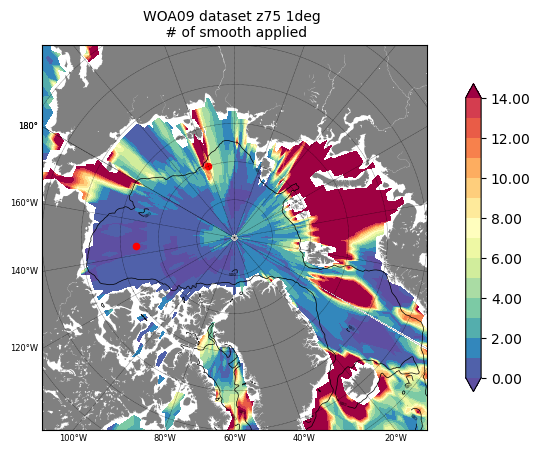

In [99]:
plt.figure(figsize=(10,5))

ds_woa09_z75['cum_smooth']=xr.where(np.isnan(mask2D),np.nan,ds_woa09_z75['cum_smooth'])

#plt.subplot(221)
Arc_Bat(ztype='isol500')
m=Arc_plot(wlon2D,wlat2D,ds_woa09_z75['cum_smooth'],np.arange(0,15),[0.,15.],zmy_cmap='Spectral_r')
loc_x=140  ;  loc_y=80
x,y = m(loc_x,loc_y)
m.scatter(x,y,20,marker='o', color='r')
loc_x=215  ;  loc_y=77
x,y = m(loc_x,loc_y)
m.scatter(x,y,20,marker='o', color='r')
plt.title( 'WOA09 dataset z75 1deg \n # of smooth applied',fontsize=10)

> # Output into NetCDF

In [66]:
if False:
    INDIR="./"
    #INDIR="/data0/project/drakkar/CONFIGS/CREG12.L75/CREG12.L75-I/"
    
    # From SA/CT to PS/PT units
    ds_SP=gsw.conversions.SP_from_SA(ds_woa09_z75['SA_sm'],pressure,ds_woa09_z75['lon'],ds_woa09_z75['lat'] )
    ds_PT=gsw.conversions.pt_from_CT(ds_woa09_z75['SA_sm'],ds_woa09_z75['CT_sm'] )
    
    ds_out=xr.Dataset()
    # Save WOA09 Practical Salinity 
    ds_out['s_an']=(('time_counter','z','lat0','lon0'),ds_SP.values)
    ds_out.coords['lat']=(('lat0'),ds_woa09_z75['lat'].values)
    ds_out.coords['lon']=(('lon0'),ds_woa09_z75['lon'].values)

    ds_out.attrs['History']='Salinity has been vertically smoothed 3 times with a 3 points window '
    ds_out.to_netcdf(INDIR+'woa09_salinity_monthly_1deg_s_an_CMA_drowned_Ex_L75_SM3.nc',unlimited_dims='time_counter')
    
    ds_out=xr.Dataset()
    # Save WOA09 Potential Temperature 
    ds_out['t_an']=(('time_counter','z','lat0','lon0'),ds_PT.values)
    ds_out.coords['lat']=(('lat0'),ds_woa09_z75['lat'].values)
    ds_out.coords['lon']=(('lon0'),ds_woa09_z75['lon'].values)

    ds_out.attrs['History']='Temperature has been vertically smoothed 3 times with a 3 points window '
    ds_out.to_netcdf(INDIR+'woa09_temperature_monthly_1deg_t_an_CMA_drowned_Ex_L75_SM3.nc',unlimited_dims='time_counter')

> # Plot a T/S diagram to look at the changes in water mass between the original WOA09 and the one smoothed

In [24]:
# Build the density contours 
temp=np.arange(-2.,2.,0.1) ; sal=np.arange(30.,37.,0.1)
temp2D=np.tile(temp,(sal.size,1)).T
ztmp=np.reshape(sal,(1,sal.size))
sal2D=np.tile(ztmp,(temp.size,1))

sig0=gsw.density.sigma0(sal2D,temp2D)
sig0.shape

(40, 70)

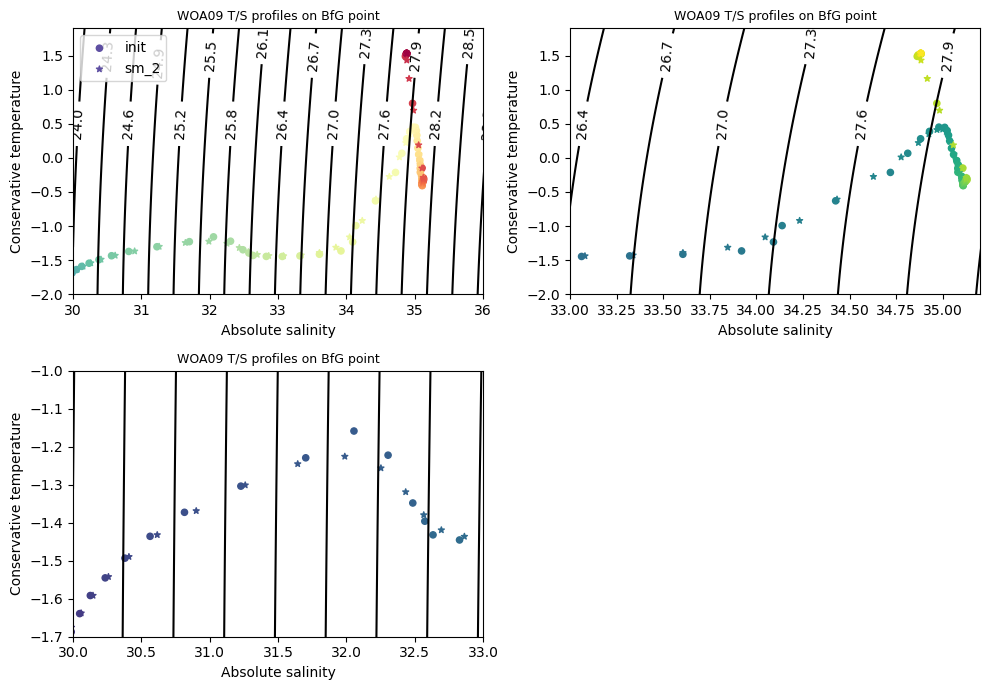

In [58]:
plt.figure(figsize=(10,7))

# Latitude & longitude
#loc_x=140.  ;  loc_y=80. ; filext='EuR'  # Eurasia
loc_x=215  ;  loc_y=77  ; filext='BfG'  # Beaufort Gyre 

tsmo='sm_'+str(num_smooth)

cast_CT=ds_woa09_z75['CT'].isel(time_counter=0).sel(lat=loc_y,lon=loc_x,method='nearest')
cast_SA=ds_woa09_z75['SA'].isel(time_counter=0).sel(lat=loc_y,lon=loc_x,method='nearest')

cast_CT_sm=ds_woa09_z75['CT_sm'].isel(time_counter=0).sel(lat=loc_y,lon=loc_x,method='nearest')
cast_SA_sm=ds_woa09_z75['SA_sm'].isel(time_counter=0).sel(lat=loc_y,lon=loc_x,method='nearest')

# Profondeurs associées (on suppose que la coordonnée verticale s'appelle 'depth')
#profondeur = ds_woa09_z75['depth'].values
profondeur=np.arange(ds_woa09_z75.sizes['z'])

plt.subplot(221)
CS=plt.contour(sal2D,temp2D,sig0,levels=20,colors='k')
plt.clabel(CS,CS.levels)
plt.scatter(cast_SA,cast_CT,20,marker='o',c=profondeur,label='init',cmap='Spectral_r')
plt.scatter(cast_SA_sm,cast_CT_sm,20,marker='*', c=profondeur,label=tsmo,cmap='Spectral_r')
plt.title('WOA09 T/S profiles on '+filext+' point',fontsize=9)
plt.ylabel('Conservative temperature')
plt.xlabel('Absolute salinity')
plt.xlim([30,36])

plt.legend(loc='upper left')
#plt.grid(True)

if True :
    plt.subplot(222)
    CS=plt.contour(sal2D,temp2D,sig0,levels=20,colors='k')
    plt.clabel(CS,CS.levels)
    plt.scatter(cast_SA,cast_CT,20,marker='o', c=profondeur,label='init',cmap='Spectral_r')
    plt.scatter(cast_SA_sm,cast_CT_sm,20,marker='*', c=profondeur, label=tsmo,cmap='Spectral_r')
    plt.title('WOA09 T/S profiles on '+filext+' point',fontsize=9)
    plt.ylabel('Conservative temperature')
    plt.xlabel('Absolute salinity')
    plt.xlim([33,35.2])
    #plt.legend()
    #plt.grid(True)
if True :
    plt.subplot(223)
    CS=plt.contour(sal2D,temp2D,sig0,levels=20,colors='k')
    plt.clabel(CS,CS.levels)
    plt.scatter(cast_SA,cast_CT,20,marker='o',c=profondeur,label='init',cmap='Spectral_r')
    plt.scatter(cast_SA_sm,cast_CT_sm,20,marker='*', c=profondeur,label=tsmo,cmap='Spectral_r')
    plt.title('WOA09 T/S profiles on '+filext+' point',fontsize=9)
    plt.ylabel('Conservative temperature')
    plt.xlabel('Absolute salinity')
    plt.xlim([30,33])
    plt.ylim([-1.7,-1.])
    #plt.legend()
    #plt.grid(True)
 
plt.tight_layout()

if True:
    plt.savefig('./WOA09_z75_smoothing_DiagTS_'+filext+'_'+tsmo+'.png',dpi=300)